In [1]:
import sys
sys.path.append("../src/")

In [2]:
%load_ext autoreload
%autoreload 2
import data_utils as du

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import torch.optim as optim


In [4]:
data = du.get_wiki_data(100)

INFO:absl:No config specified, defaulting to first: wiki40b/en
INFO:absl:Load dataset info from gs://tfds-data/datasets/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (gs://tfds-data/datasets/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split train[:100], from gs://tfds-data/datasets/wiki40b/en/1.3.0


In [247]:
sent_reprs = du.encode_data(data[:5])

In [248]:
len(sent_reprs)

71

In [249]:
from training import ModelRunner

In [497]:
args = "--epochs 2 --emsize 768 --nhid 1536 --bptt 10 --batch_size 4 --dropout 0 --nlayers 2"
runner = ModelRunner(args.split())

In [498]:
runner.model.train()

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=1536, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=1536, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=

In [499]:
import numpy as np
import torch

batch_size = runner.args.batch_size
bptt = runner.args.bptt
total = batch_size * bptt
print(batch_size, bptt, total)

def get_vars_from_sent(sent_reprs):
    reprs = []
    for sent_repr in sent_reprs:
        for verb_repr in sent_repr:
            for tag, vec in verb_repr:
                reprs.append(vec)
    return np.array(reprs)
full_data = get_vars_from_sent(sent_reprs)
input_data = full_data[0:total]
target_data = full_data[1:total+1]
input_data = torch.tensor(input_data)
input_data = input_data.view(batch_size, bptt, -1).permute(1,0,2)
target_data = torch.tensor(target_data)
target_data = target_data.view(batch_size, bptt, -1).permute(1,0,2)

4 10 40


In [500]:
for i in range(bptt-1):
    assert torch.equal(input_data[i+1], target_data[i])

In [501]:
input_data.shape

torch.Size([10, 4, 768])

In [502]:
target_data.shape

torch.Size([10, 4, 768])

In [503]:
    #candidates = torch.rand(16, 768)
    #target_options = target_data.reshape(-1, 768)
    #for i in range(4):
    #    candidates[i*4] = target_options[i]
#     logits = torch.stack([logits[0,:5],
#            logits[1,4:9],
#            logits[2,8:13],
#            logits[3,11:16]])

In [514]:
criterion = torch.nn.CrossEntropyLoss()

# optimizer = optim.SGD(runner.model.parameters(), lr=20, momentum=0.9)

losses = []
all_acc = []
for _ in range(100):
    runner.model.zero_grad()
    output = runner.model(input_data)
    logits = torch.matmul(output.reshape(-1, 768), target_data.reshape(-1, 768).t())
    tmp = torch.diag_embed(torch.tensor([float('-inf')]*(total - 1)), offset=-1)
    index = torch.LongTensor([0]+ list(range(total-batch_size+1,total))+ list(range(1,total-batch_size+1)))
    mask_self_dot = tmp[index]
    logits = logits + mask_self_dot
    labels = torch.tensor(list(range(total)))
    loss = criterion(logits, labels)
    acc = torch.sum(torch.argmax(logits, axis=1) == labels) / total
    all_acc.append(acc)
    # loss = runner.criterion(output, target_data)
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(runner.model.parameters(), 0.25)
    for p in runner.model.parameters():
        p.data.add_(p.grad, alpha=-.001)
    # optimizer.step()
    losses.append(loss.item())

In [520]:
torch.argmax(logits, axis=1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 18, 35,
        36, 37, 38, 39])

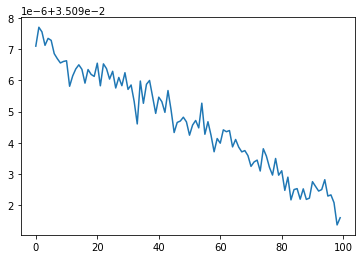

In [516]:
plt.plot(losses)

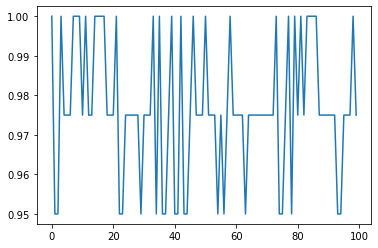

In [517]:
plt.plot(all_acc)

In [519]:
losses[-20:]

[0.035093098878860474,
 0.035092469304800034,
 0.03509289398789406,
 0.03509216383099556,
 0.03509249538183212,
 0.03509252518415451,
 0.03509218618273735,
 0.035092517733573914,
 0.035092178732156754,
 0.03509221971035004,
 0.03509274870157242,
 0.03509259596467018,
 0.03509244695305824,
 0.03509249538183212,
 0.03509281203150749,
 0.03509228676557541,
 0.035092324018478394,
 0.0350920744240284,
 0.03509135916829109,
 0.0350915901362896]

# Issues
* The model doesn't train very well, even with small data.
* Although with careful optimization we can memorize the problem seems hard
* If we use random negatives, it becomes much easier so clearly the problem is just very hard.
* In this case, all vectors are from 2 adjacent sentences. Real data will have to be much easier.
* Although I am only trying to memorize, the real model will have lots of data and training time.
* maybe better without positional encodings

## TODO
* Example where we memorize on hard examples
* Easy examples with random negatives to show it works
* Same as above but with examples from other documents.
* Think about eval

# TODO

* Implement actual model (contrastive)
    * Move code to runnable module
    * Add distance metric or triplet loss? 
    
* Build data pipeline
* Run training / eval
    * cluster

# Thoughts and issues with modeling

## Determinism
* There is an issue with ordering. If you don't condition on anything the next token can be anything. Currently we have  a V,A0,A1... structure which the model will probably figure out. However, the order of verbs might be not obvious, especially if the entities are unknown. 
* We could use some conditioning like conditioning on the role name (eg. V or A1). This could  be included in the prediction / decoding
* We could give some non-linear hints (predict A0 given V and V given A0). There might be some leakage from the representations. 
* We need a sentence level objective here as well.
* Maybe the structure doesn't matter and the model will just figure it out.
* Even if we condition, there could be multiple verbs that are reasonable. Maybe we need a variational objective.